## Sound source localization via multiarray DOA & NN

### Loading modules, make data classes

### set up experiment, choose data

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["grid.color"]='#e5e5e5'
!mkdir -p ./fig

import sys

try:
    import pandas
    import torch
except ImportError:
    print('Not all modules found, try installing')
    !{sys.executable} -m pip install pandas
    !{sys.executable} -m pip install pickle # needed for python <3.9
    !{sys.executable} -m pip install torch
    import torch
    
from importlib import reload
from torch.utils.data import DataLoader
from utils import MultiarrayDoaDataset, get_test_data, show_localization, affine_transform, plot_singular_values

In [2]:
# SEPT 29th
filepath = './data/29_Sep2021_allData.p'
out_dim = 3
# all
filter_array_idx = [] # indices of arrays to discard throughout experiment
TRAINING_POINTS = [] # indices of points to use, if empty, use all 0-17

# full data set for calibration of affine mapping
#filter_array_idx = [1,2,7] # only keep 3,4,5,6
#TRAINING_POINTS = [1,2,3,4,5,6,7,8,9,10,12,13,16,17] # all points with full calibration measruemetns arrays 2345

# further reduce for jasa-el experiments
TRAINING_POINTS  = [1,6,9]#+[4]
filter_array_idx = [1,2,7]
DOAS_PER_CPOINT  = 100 

In [3]:
#GET TRAINING DATA
MultiarrayDoaDataset=reload(sys.modules['utils']).MultiarrayDoaDataset

tag = filepath.split('/')[-1].split('.')[0]

training_data    = MultiarrayDoaDataset(filepath, TRAINING_POINTS, out_dim, filter_array_idx, 
                                        b_divide_by_z = True, testset_split = DOAS_PER_CPOINT)
train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)

if out_dim > training_data.calib_doa.shape[1]: #"one array can not localize 3d"
    out_dim = np.min([out_dim,training_data.calib_doa.shape[1]]) 
    print("underdetermined problem, fewer ins than outs. reducing outs")

In [4]:
# GET TEST DATA
test_keys =  [
        'rectangle', 
        'inner', 
        'counter',]
get_test_data=reload(sys.modules['utils']).get_test_data

test_cases, test_labels, test_zref = get_test_data(
    filepath,out_dim, test_keys=test_keys,
    remove_array_idx=filter_array_idx,doa_offset=training_data.calib_doa_offset,b_divide_by_z = True)

mean 3.5762786e-09
min -0.7712238
max 0.6227579
sshape (300, 8)


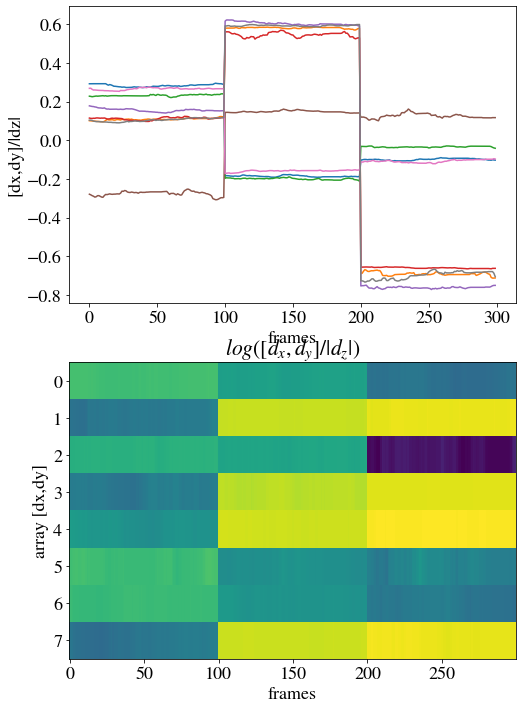

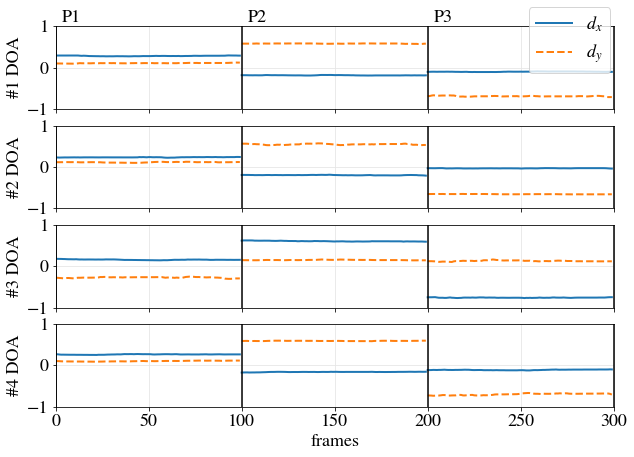

In [5]:
# inspect training data
print("mean", np.nanmean(training_data.calib_doa))
print("min", np.nanmin(training_data.calib_doa))
print("max", np.nanmax(training_data.calib_doa))
print("sshape", training_data.calib_doa.shape)

n0,n1 = 0,None
import matplotlib.pyplot as plt
plt.figure(1, figsize=(8,12))
plt.clf()
plt.subplot(211)
plt.plot(training_data.calib_doa[n0:n1])
plt.ylabel('[dx,dy]/|dz|')
plt.xlabel('frames')
plt.subplot(212)
plt.imshow(np.log(np.abs(training_data.calib_doa[n0:n1])).T, interpolation='none')
plt.title('$log([d_x,d_y]/|d_z|$)')
plt.ylabel('array [dx,dy]')
plt.xlabel('frames')
plt.gca().set_aspect('auto')
plt.savefig('./fig/'+tag+'_calib_data.png',bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(10,7))
training_labels = ["P1","P2","P3","P4","P5","P6"]
numplots = 4 # arrays
for jj in range(numplots):
    ax = plt.subplot(numplots,1,jj+1)
    oold = [0]
    for tmp in [
            training_data.calib_doa[  :DOAS_PER_CPOINT],
            training_data.calib_doa[1*DOAS_PER_CPOINT:2*DOAS_PER_CPOINT],
            training_data.calib_doa[2*DOAS_PER_CPOINT:],
        ]:
        oold.append(oold[-1]+len(tmp))
        if oold[-2] == 0:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj],label='$d_x$',lw=2)
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],label='$d_y$',lw=2,ls='--')
        else:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj]  ,'C0',lw=2)
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],'C1',lw=2,ls='--')
    [ax.axvline(oo,c='k') for oo in oold]
    plt.xlim([oold[0],oold[-1]])
    if ax.get_ylim()[0]>-1: ax.set_ylim([-1,ax.get_ylim()[1]])
    if ax.get_ylim()[0]< 1: ax.set_ylim([ax.get_ylim()[0],1])
    ax.set_ylabel("#{} DOA".format(training_data.arrays[jj]),x=-2.20)
    ax.set_xticks(np.arange(oold[0],oold[-1],1000), minor=True)
    ax.set_xticks(np.arange(oold[0],oold[-1],500), minor=True)
    plt.grid(True,which='both')
    if jj == 0:
        [ax.annotate(training_labels[ii],(oo/oold[-1]+.01,1.05),xycoords='axes fraction') 
             for ii,oo in enumerate(oold[:-1])]
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor = (1.01,1.34))
    if jj+1<numplots: ax.set_xticklabels([])
    else: ax.set_xlabel('frames')
plt.savefig('./fig/'+tag+'_training_data.pdf',bbox_inches='tight', pad_inches=0)

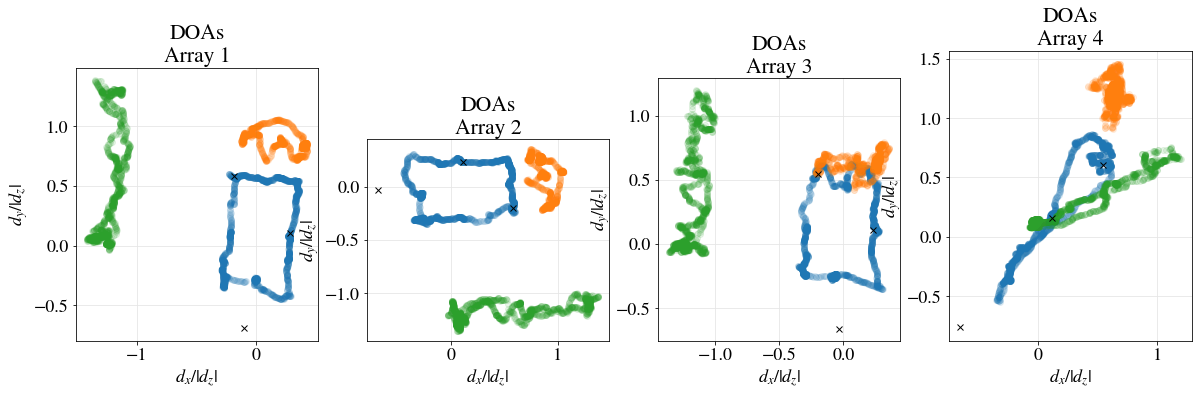

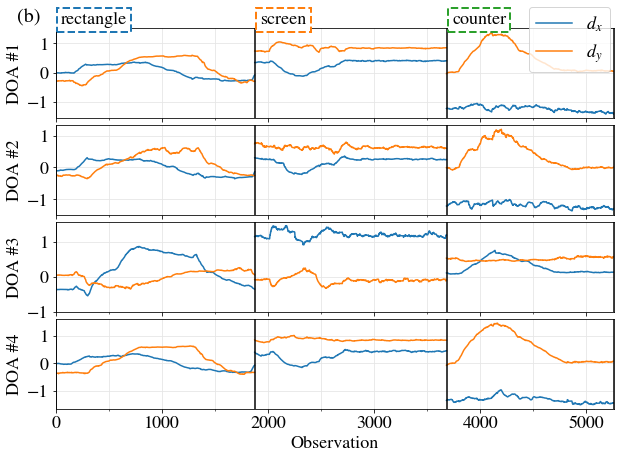

In [6]:
# inspect calibration points vs training or test data series
# tmp = test_all[n0:n1,:]
# tmp = training_data.calib_doa

Na = training_data.N_arrays
numplots = np.min([7,Na])

plt.figure(figsize=(20,8))
cpointdata = 1/np.array([
    np.nanmean(1/training_data.calib_doa[training_data.calib_id == ii],axis=0) 
    for ii in range(training_data.N_points)])
jj = 0
for ii in range(numplots):
    ax = plt.subplot(1,numplots,ii+1)
    while (np.all(np.isnan(cpointdata[:,jj])) | np.all(cpointdata[:,jj]==0)): jj+=1
    for tmp in test_cases:
        ax.plot(tmp[:,jj],tmp[:,jj+1],'o',alpha=.1)
    ax.plot(cpointdata[:,jj],cpointdata[:,jj+1],'kx')
    ax.set_title("DOAs\nArray {}".format(training_data.arrays[jj]))
    ax.set_xlabel('$d_x/|d_z|$')
    ax.set_ylabel('$d_y/|d_z|$')
    ax.set_aspect('equal')
    ax.set_anchor('SW')
    plt.grid()
    jj +=1

fig = plt.figure(figsize=(10,7.0))
for jj,gsi in enumerate(GridSpec(numplots,1,hspace=.08)):
    ax = fig.add_subplot(gsi)
    oold = [0]
    for tmp in test_cases:
        oold.append(oold[-1]+len(tmp))
        if oold[-2] == 0:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj],label="$d_x$")
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],label='$d_y$')
        else:
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj]  ,'C0')
            ax.plot(np.arange(oold[-2],oold[-1]),tmp[:,2*jj+1],'C1')
    [ax.axvline(oo,c='k') for oo in oold]
    ax.set_xlim([oold[0],oold[-1]])
    if ax.get_ylim()[0]>-1:
        ax.set_ylim([-1,ax.get_ylim()[1]])
    ax.set_ylabel("DOA #{}".format(training_data.arrays[jj]),x=-2.20)
    #ax.set_xticks(oold+[1000,3000,4500],minor=False)
    ax.set_xticks(np.arange(oold[0],oold[-1],1000), minor=True)
    ax.set_xticks(np.arange(oold[0],oold[-1],500), minor=True)
    plt.grid(True,which='both')
    if jj == 0:
        [ax.annotate(test_labels[ii],(oo/oold[-1]+.01,1.05),xycoords='axes fraction',
                     bbox=dict(color=f'C{ii}',fc='white',lw=2,linestyle='dashed')) 
             for ii,oo in enumerate(oold[:-1])]
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor = (1.01,1.34))
        plt.text(-.07,1.07,"(b)",fontsize=20,transform=ax.transAxes)
    if jj+1<numplots: ax.set_xticklabels([])
    else: ax.set_xlabel('Observation')
plt.savefig('./fig/'+tag+'_test_data.pdf',bbox_inches='tight', pad_inches=0)
    
plt.show()

## LA model

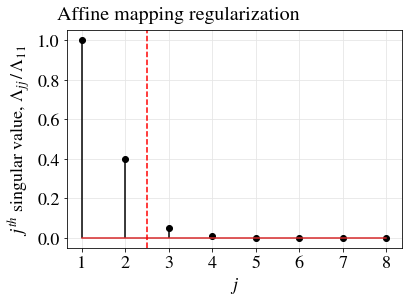

In [7]:
show_localization=reload(sys.modules['utils']).show_localization
affine_transform=reload(sys.modules['utils']).affine_transform
plot_singular_values=reload(sys.modules['utils']).plot_singular_values

# SETTING MACROS
LM_TRUNC = out_dim # automatically adjusted to 2 for one array
LM_TRUNC = 4 # NO TRUNCATION
LM_TRUNC = 2 # 2D localization only

sv = [1.0000000e+00, 4.0148419e-01, 4.7637947e-02 ,1.1508125e-02 ,3.0449891e-04 ,7.9183585e-05 ,3.9138173e-05 ,2.6038646e-05]
plot_singular_values(sv,LM_TRUNC)


(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05 4.8096525e-05
 4.1361163e-05 2.4318351e-05 8.0743439e-06] 
 - condition number: 123849.06
 - kept singular values [1.         0.12816717] 
 - new condition number: 7.8023105
MSE training:  8.909478783607483e-05
affine mapping fit
SVD truncated at 2.00


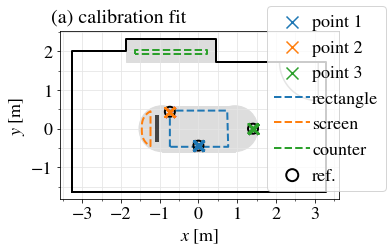

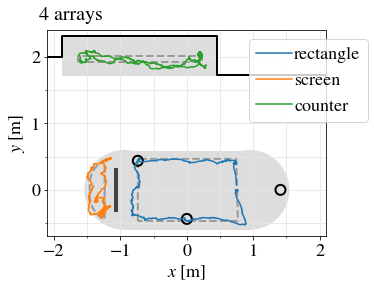

In [8]:
## LINEAR MAPPING FULL CASE
#rcond = .01 # truncate singular vectors < .01 (normalized by maximum)

B, R_0, U,sigma ,VH = affine_transform(
    training_data.calib_doa.T, 
    training_data.calib_xy[training_data.calib_id].T, 
    trunc = LM_TRUNC,
)

affine_predict = lambda doa: (R_0 + B @ doa.T).T

# Analyze fit
fit = [affine_predict(training_data.calib_doa[training_data.calib_id==ii]) for ii in np.unique(training_data.calib_id)]
reference = training_data.calib_xy[training_data.calib_id]
print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
print('affine mapping fit\nSVD truncated at {:.2f}'.format(LM_TRUNC))
label= [f'point {ii+1}' for ii in range(len(TRAINING_POINTS))] 
show_localization(fit, training_data, label=label ,title='(a) calibration fit', color_refs=True, lopts=dict(bbox_to_anchor=(1.2,1.2)))
plt.savefig('./fig/'+tag+'_0_affine_reference_calib.pdf',bbox_inches='tight',pad_inches=0)

# predict test data localizations
predictions = [affine_predict(td.numpy()) for td in test_cases]
opts = {'ylims':[-.7,2.4],'xlims':[-2.1,2.1]}
label= 'affine mapping prediction\nSVD truncated at {:.2f}'.format(LM_TRUNC)
label = test_labels
show_localization(predictions, training_data, label=label ,**opts,title = "4 arrays")
plt.savefig('./fig/'+tag+'_0_affine_reference.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

In [9]:
## LINEAR MAPPING DEMO CASE FOR ARRAY SUBSETS
def run_test(deactivate_arrays_sequence, trunc = LM_TRUNC, b_concat_cases = False, **data_kwargs): # run test with affine mapping from array subset. input list of 3,4,5,6 to choose which arrays to drop
    predictions = list()
    for jj,deactivate in enumerate(deactivate_arrays_sequence):
        
        # SEPT 29th
        b_divide_by_z = True # [x,y]/z instead of [x,y,z] doa vectors
        filepath = './data/29_Sep2021_allData.p'
        out_dim = 3

        # only full data set for calibration of affine mapping
        filter_array_idx = [1,2,7] # only keep 3,4,5,6
        filter_array_idx += [dd+2 for dd in deactivate] # offset to start at 3...
        training_data    = MultiarrayDoaDataset(filepath, TRAINING_POINTS, out_dim, filter_array_idx, 
                                                testset_split = DOAS_PER_CPOINT, **data_kwargs)
        print("arrays",training_data.arrays, f"J={trunc}")

        train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)
        #"one array can not localize 3d"
        if trunc is not None and trunc > training_data.calib_doa.shape[1]:
            trunc = np.min([trunc,training_data.calib_doa.shape[1]]) 
            print("underdetermined problem, fewer ins than outs. reduce outs")

        B, R_0, U,sigma ,VH = affine_transform(
            training_data.calib_doa.T, 
            training_data.calib_xy[training_data.calib_id].T, 
            trunc = trunc) 
        affine_predict = lambda doa: (R_0 + B @ doa.T).T

        # Analyze fit
        fit = [affine_predict(training_data.calib_doa[training_data.calib_id==ii]) for ii in np.unique(training_data.calib_id)]
        reference = training_data.calib_xy[training_data.calib_id]
        print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
        #show_localization(fit, 'C{:d}'.format(jj), 'affine mapping fit\nSVD truncated at {:.2f}'.format(rcond), r0=R_0)
        #plt.savefig('./fig/'+tag+'_0_affine_reference_calib.pdf',bbox_inches='tight',pad_inches=0)

        # predict test data localizations
        test_keys =  [ 'rectangle',  'inner',  'counter', ]
        test_cases,_,_ = get_test_data(filepath, out_dim, 
                                     test_keys=test_keys, 
                                     remove_array_idx = filter_array_idx, 
                                     doa_offset=training_data.calib_doa_offset,
                                     **data_kwargs)

        test_predictions = [affine_predict(td.numpy()) for td in test_cases]
        if b_concat_cases: predictions.append(np.vstack(test_predictions))
        else: predictions += test_predictions

        # predictions = [affine_predict(td.numpy()) for td in test_cases]
        # opts = {'color':'C{:d}'.format(jj), 'label':'affine mapping prediction\nSVD truncated at {:.2f}'.format(rcond), 'r0':R_0}
        # if jj == 0: axes = show_localization(predictions, **opts)
        # else: axes = show_localization(predictions,axes=axes, **opts)
    return predictions

def list_diff(list1, list2): 
    return (list(set(list1) - set(list2)))

In [10]:
# all arrays, proposed method and ref 11
predictions_proposed = run_test([[]], b_divide_by_z=True)
predictions_state    = run_test([[]], b_divide_by_z=False)
"""testset_split = DOAS_PER_CPOINT should be given to run_test() to split sets that both are in calibration and test (e.g. 'ground', 'window', 'door')..."""

arrays [1 2 3 4] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05 4.8096525e-05
 4.1361163e-05 2.4318351e-05 8.0743439e-06] 
 - condition number: 123849.06
 - kept singular values [1.         0.12816717] 
 - new condition number: 7.8023105
MSE training:  8.909478783607483e-05
arrays [1 2 3 4] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.6821745e-01 8.1363352e-05 4.8800463e-05 3.8606573e-05
 2.4884366e-05 1.9701018e-05 1.0630216e-05 7.9302936e-06 4.9154492e-06
 2.7290976e-06 1.6460880e-06] 
 - condition number: 607500.94
 - kept singular values [1.         0.16821745] 
 - new condition number: 5.9446864
MSE training:  5.2251312881708144e-05


"testset_split = DOAS_PER_CPOINT should be given to run_test() to split sets that both are in calibration and test (e.g. 'ground', 'window', 'door')..."

In [11]:
# Subsets of three, two, one array(s)
sequence3 = [[4],[3],[2],[1]]
sequence2 = [[3,4],[2,4],[2,3],[1,4],[1,3],[1,2]]
sequence1 = [[2,3,4],[1,3,4],[1,2,4],[1,2,3]]
predictions3 = run_test(sequence3)
predictions2 = run_test(sequence2)
predictions1 = run_test(sequence1)

arrays [1 2 3] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2877958e-01 7.3595183e-05 6.4136984e-05 5.2522882e-05
 1.3242788e-05] 
 - condition number: 75512.805
 - kept singular values [1.         0.12877958] 
 - new condition number: 7.765207
MSE training:  0.00011760464558998744
arrays [1 2 3] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.3205361e-01 1.6777200e-04 5.8787653e-05 3.6990634e-05
 1.3584168e-05] 
 - condition number: 73615.11
 - kept singular values [1.         0.13205361] 
 - new condition number: 7.572682
MSE training:  0.00010635681450366973
arrays [1 2 3] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.3051523e-01 1.6160772e-04 6.2193816e-05 5.8431953e-05
 2.8521259e-05] 
 - condition number: 35061.566
 - kept singular values [1.         0.13051523] 
 - new condition number: 7.6619406
MSE training:  0.00012022395928700765
arrays [1 2 3] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2090069e-01

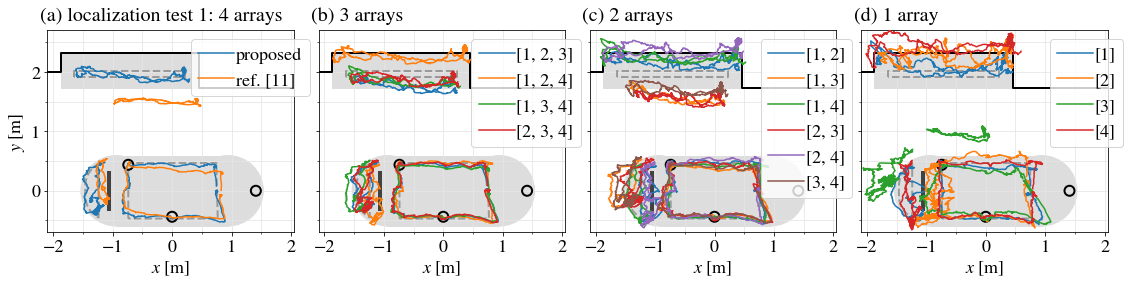

In [30]:
plot_singular_values=reload(sys.modules['utils']).plot_singular_values

fig=plt.figure(figsize=(19,6))
axes = [fig.add_subplot(gsi) for gsi in GridSpec(1,4,wspace=.1)]

lopts = dict(bbox_to_anchor=(1.1,1.0))
opts  = dict(ylims=[-.7,2.7], xlims=[-2.1,2.05], lopts=lopts, label = [ "proposed","","", "ref. [11]","","", ], title="(a) localization test 1: 4 arrays", ax=axes[0])
show_localization(predictions_proposed+predictions_state, training_data, **opts, color=[ 'C0','C0','C0', 'C1','C1','C1',])

opts.update(dict(label=[str(list_diff([1,2,3,4],ss)) for ss in sequence3], title="(b) 3 arrays", ax=axes[1]))
show_localization(predictions3, training_data, **opts)
opts.update(dict(label=[str(list_diff([1,2,3,4],ss)) for ss in sequence2], title="(c) 2 arrays", ax=axes[2]))
show_localization(predictions2, training_data, **opts)
opts.update(dict(label=[str(list_diff([1,2,3,4],ss)) for ss in sequence1], title = "(d) 1 array", ax=axes[3]))#, lopts=dict(bbox_to_anchor=(1.0,1.1)))
show_localization(predictions1, training_data, **opts)

#for ax in axes[:3]:
    #ax.set_xlabel("")
    #ax.set_xticklabels([])
for ax in axes[1:]:
    ax.set_ylabel("")
    ax.set_yticklabels([])


plt.savefig('./fig/'+tag+'_0_affine_all.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

In [31]:
# example with different regularization (PCA truncation J)
J = [2,4,6]
preds = list()
[preds.extend(run_test([[]],trunc=jj)) for jj in J]
labels = [f'J={jj}' for jj in J]

arrays [1 2 3 4] J=2
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05 4.8096525e-05
 4.1361163e-05 2.4318351e-05 8.0743439e-06] 
 - condition number: 123849.06
 - kept singular values [1.         0.12816717] 
 - new condition number: 7.8023105
MSE training:  8.909478783607483e-05
arrays [1 2 3 4] J=4
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05 4.8096525e-05
 4.1361163e-05 2.4318351e-05 8.0743439e-06] 
 - condition number: 123849.06
 - kept singular values [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05] 
 - new condition number: 17030.426
MSE training:  6.638909379641216e-05
arrays [1 2 3 4] J=6
(D-D_mean)@D^T
 - singular values (scaled): [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05 4.8096525e-05
 4.1361163e-05 2.4318351e-05 8.0743439e-06] 
 - condition number: 123849.06
 - kept singular values [1.0000000e+00 1.2816717e-01 1.3671548e-04 5.8718437e-05 4.80965

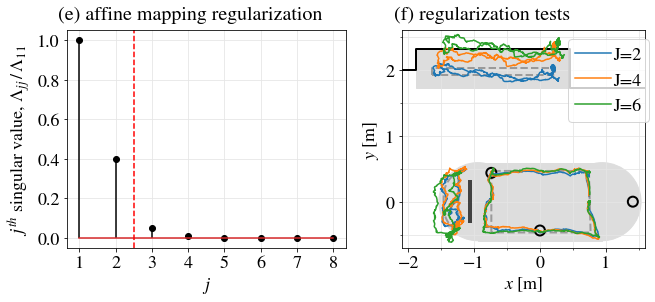

In [32]:
plot_singular_values=reload(sys.modules['utils']).plot_singular_values

fig=plt.figure(figsize=(11,4))
gs = GridSpec(1,2,wspace=.2)
ax = fig.add_subplot(gs[0])
plot_singular_values(sv,LM_TRUNC,ax=ax,title="(e) affine mapping regularization")
#Jr = [jj for jj in J]; Jr.reverse()
#for ii,jj in enumerate(Jr):
#    print(ii,jj,sv[:jj])
#    ax.stem(np.arange(1,jj+1),sv[:jj],markerfmt=f'oC{2-ii}',linefmt=f'C{2-ii}')

opts = dict(label=labels, ylims=[-.7,2.6],xlims=[-2.1,1.6], lopts=dict(bbox_to_anchor=(1.05,1.)))
show_localization(preds, training_data, **opts, title="(f) regularization tests", ax=fig.add_subplot(gs[1]))

plt.savefig('./fig/'+tag+'_0_affine_reg.pdf'.format(3),bbox_inches='tight', pad_inches=0)
plt.show()

### Build and train single layer network

In [15]:
from torch import nn
class SingleLayer(nn.Module):
    def __init__(self, N_in, N_out):
        super(SingleLayer, self).__init__()
        self.linear_stack = nn.Sequential(
            #nn.Linear(N_in, N_in),
            #nn.ReLU(),
            nn.Linear(N_in, N_out),
        )
        
    def forward(self, x):
        return self.linear_stack(x)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    mse = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mse += loss.item()
        #if batch % 2000 == 0:
            #loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return mse
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}")

In [17]:
singlelayer = SingleLayer(training_data.calib_doa.shape[1],out_dim)

learning_rate = 3e-2
batch_size = 300
epochs = 1000
weight_decay=.0005 #somewhat equal to truncated svd in the linear case
#weight_decay=0 # no regularization
b_truncate_training_data_nn = False

training_data    = MultiarrayDoaDataset(filepath, TRAINING_POINTS, out_dim, filter_array_idx)
train_dataloader = DataLoader(training_data, batch_size = 5, shuffle = True)
if b_truncate_training_data_nn:
    _,_, U,sigma ,VH = generate_linear_transform_matrix(
        training_data.calib_doa.T, 
        training_data.calib_xy[training_data.calib_id].T, 
        trunc = LM_TRUNC) 
    training_data.calib_doa = ((U[:,:LM_TRUNC]@np.diag(sigma[:LM_TRUNC]))@VH[:LM_TRUNC]).T

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(singlelayer.parameters(), lr=learning_rate, weight_decay=weight_decay)

mse = np.zeros(epochs)
for t in range(epochs):
    mse[t] = train_loop(train_dataloader, singlelayer, loss_fn, optimizer)
    print(f"{t+1}-{mse[t]:3.5f}")
    #test_loop(traintest_dataloader, singlelayer, loss_fn)
print("Done!")
plt.semilogy(mse)

mkdir: cannot create directory ‘./fig/’: File exists
MSE training:  1.859117365126421


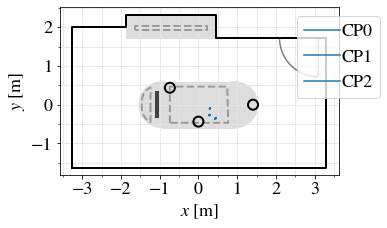

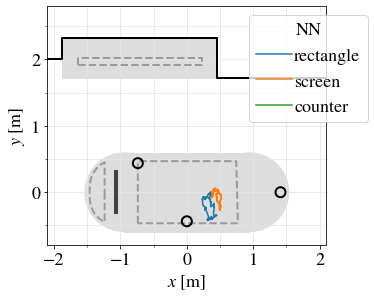

In [18]:
layers = [x.data for x in singlelayer.parameters()]
!mkdir ./fig/

nid = np.unique(training_data.calib_id)
cdlist = [training_data.calib_doa[training_data.calib_id == ii] for ii in nid]
fit = [singlelayer(torch.Tensor(cd)).detach().numpy() for cd in cdlist]
reference = training_data.calib_xy[training_data.calib_id]
print("MSE training: ", np.sum((np.vstack(fit)-reference)**2)/len(reference))
label = 'single layer training data fit'
label = [f'CP{ii}' for ii in range(len(TRAINING_POINTS))]
show_localization(fit, training_data, 'C0', label=label)
plt.savefig('./fig/'+tag+'_1_single_layer_calib.pdf',bbox_inches='tight', pad_inches=0)

predictions = [singlelayer(test_data).detach() for test_data in test_cases]
opts = {'ylims':[-.8,2.8],'xlims':[-2.1,2.1]}
label = 'single layer prediction'
label = test_labels
show_localization(predictions, training_data, label= label,**opts,lopts=dict(title='NN'))
plt.savefig('./fig/'+tag+'_1_single_layer.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

### parameters of single layer NN vs affine mapping

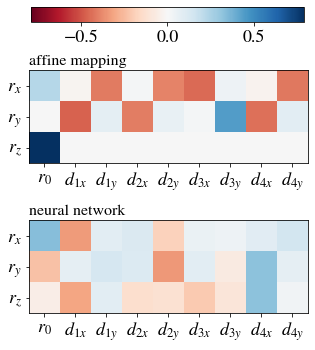

single layer NN biases tensor([ 0.3349, -0.2291, -0.0513])
affine mapping offset R_0) [[ 2.24166766e-01 -1.13840155e-08  7.89997339e-01]]


In [19]:
#print("Model structure: ", singlelayer, "\n\n")
#for name, param in singlelayer.named_parameters():
#    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    
#if b_divide_by_z: 
idxsort = np.arange(0,2*len(training_data.arrays))
#else: idxsort = np.arange(0,3*len(training_data.arrays))

fig=plt.figure(figsize=(5,5.5))
nncoeff = np.hstack([layers[-1][:,np.newaxis],layers[-2].numpy()])
afcoeff = np.hstack([R_0,B])
combined = [afcoeff.flatten(),nncoeff.flatten()]
vmax = np.max([-np.min(combined), np.max(combined)])
opts = {'cmap':'RdBu','vmin':-vmax,'vmax':vmax}
for ii in range(1,3):
    plt.subplot(2,1,ii)
    if ii == 1:
        im = plt.imshow(afcoeff,**opts)
        plt.title('affine mapping',fontsize=16,loc='left')
    elif ii == 2:
        im = plt.imshow(nncoeff,**opts)
        plt.title('neural network',fontsize=16,loc='left')
    plt.gca().set_xticks(range(9))
    xticklist = [ '$r_0$',
        '$d_{1x}$', '$d_{1y}$',
        '$d_{2x}$', '$d_{2y}$',
        '$d_{3x}$', '$d_{3y}$',
        '$d_{4x}$', '$d_{4y}$', ]
    plt.gca().set_xticklabels(xticklist)
    plt.gca().set_yticks([0,1,2])
    plt.gca().set_yticklabels(['$r_x$','$r_y$','$r_z$'])
# cbar_ax = fig.add_axes([0.85, 0.19, 0.05, 0.62]) # vertical
# fig.subplots_adjust(bottom=0.15)
# cbar_ax = fig.add_axes([.13,.05,.76,.04]) # below
fig.subplots_adjust(top=.82)
cbar_ax = fig.add_axes([.13,.90,.76,.04]) # above
fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
plt.savefig('./fig/'+tag+'_coeffs.pdf',bbox_inches='tight', pad_inches=0)
plt.show()

print('single layer NN biases', layers[-1])
print('affine mapping offset R_0)', R_0.T)